# Prevendo possíveis resultados e vencendor da copa do mundo de 2022

In [1]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import matplotlib.image as mpimg
from scipy.stats import poisson
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## **Configurações iniciais**

A primeira coisa a se fazer será importar as bases de dados conforme sofreram atualizações na etapa de análise exploratória dos dados.

In [4]:
df_partidas_internacionais = pd.read_csv('results_preProcessado.csv') 

In [5]:
df_partidas_internacionais['date'] = df_partidas_internacionais['date'].astype('datetime64[ms]')

Algo importante e que deve ser feito é adicionar uma coluna de peso que é baseada na data do jogo, porque é óbvio que um jogo que aconteceu este ano diante de todas as partidas internacionais da base de dados tem mais peso do que o primeiro jogo da data mais antiga da base.

Então, note que agora eu irei construir uma nova variável que irá servir de peso, com base na data da partida, e irei definir um novo conjunto de dados com as **variáveis que serão utilizadas para o desenvolvimento do modelo** com base na análise multivariada realizada, além de utilizar home_score e away_score como uma única variável nomeada de gols, lembrando que essa é a variável principal, tendo em vista, que foi pensado o desenvolvimento do modelo de machine learning a partir da regressão de poisson.

In [6]:
def peso_por_torneios(torneios):
    if 'Cup' in torneios or 'Euro' in torneios:
        return 1
    else :
        return 100

# criação da variável peso
df_partidas_internacionais.loc[:,'weight'] = df_partidas_internacionais['tournament'].apply(peso_por_torneios)
df_partidas_internacionais.loc[:,'weight'] = 1 / ((2022 - df_partidas_internacionais['date'].dt.year.astype('int64'))*df_partidas_internacionais['weight'])

# definindo novo conjunto de dados
matches_model_data = pd.concat([df_partidas_internacionais[['home_team','away_team','home_score','weight', 
                                                           'score_diff', 'result', 'home_elo', 'away_elo', 
                                                            'rank_home', 'rank_away', 'total_points_home', 
             'rank_difference', 'point_difference', 'score_difference', 'is_won', 'elo_difference']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals', 'home_elo':'elo','away_elo':'elo opponent',
                     'rank_home':'rank', 'rank_away':'rank opponent', 'total_points_home':'total points', 'total_points_away':'total points opponent'}),
            
            df_partidas_internacionais[['away_team','home_team','away_score','weight','score_diff', 'result', 'away_elo', 'home_elo', 
                                                            'rank_away', 'rank_home','total_points_away', 
             'rank_difference', 'point_difference', 'score_difference', 'is_won', 'elo_difference']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals', 'home_elo':'elo opponent', 'away_elo':'elo', 
                     'rank_home':'rank opponent','rank_away':'rank', 'total_points_home':'total points opponent', 'total_points_away':'total points'})])

Um entendimento rápido de como a variável de gols das partidas está distribuída e de como o novo conjunto de dados está se comportando.

/home/luis/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='goals', ylabel='Density'>

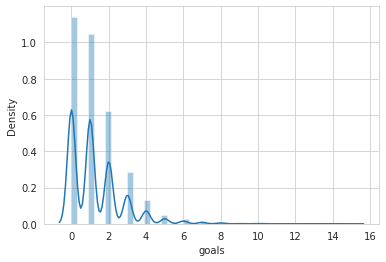

In [7]:
sns.distplot(matches_model_data['goals'])

In [8]:
matches_model_data

,team,opponent,goals,weight,score_diff,result,elo,elo opponent,rank,rank opponent,total points,rank_difference,point_difference,score_difference,is_won,elo_difference
0,Kuwait,Jordan,1,0.00125,1,0.0,1642.959148,1683.802381,105.0,65.0,315.00,40.0,-221.00,-1,False,-40.843233
1,Bahrain,Jordan,0,0.00125,1,0.0,1564.333690,1694.243957,110.0,65.0,292.00,45.0,-244.00,-1,False,-129.910267
2,Namibia,Ghana,0,0.00125,1,0.0,1411.523277,1705.773521,125.0,24.0,237.00,101.0,-612.00,-1,False,-294.250244
3,Nigeria,Ethiopia,2,0.00125,1,1.0,1726.402708,1468.188551,37.0,93.0,710.00,-56.0,336.00,1,True,258.214158
4,Qatar,Kuwait,3,0.00125,3,1.0,1607.252314,1625.689533,103.0,105.0,325.00,-2.0,10.00,3,True,-18.437218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,El Salvador,Mexico,0,inf,2,1.0,1548.858160,1831.836800,70.0,12.0,1346.04,-58.0,301.86,2,True,282.978640
6458,United States,Costa Rica,0,inf,2,1.0,1838.671339,1714.827795,13.0,42.0,1643.34,29.0,-179.28,2,True,-123.843544
6459,Canada,Panama,0,inf,1,1.0,1749.532386,1655.240978,33.0,63.0,1497.82,30.0,-122.26,1,True,-94.291408
6460,Honduras,Jamaica,1,inf,1,1.0,1517.547787,1586.083536,78.0,62.0,1303.96,-16.0,74.66,1,True,68.535748


Note que alguns dados estão como "inf" e por isso irei realizar uma transformação desses dados.

In [9]:
matches_model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

Após finalizar essas configurações iniciais e definição dos dados que serão utilizados no modelo, pode-se começar de fato a construção do modelo de machine learning.

## Modelo Linear Generalizado (GLM) - Regressão de poisson

O modelo será construído com base na regressão de Poisson, sendo uma forma de modelo linear generalizado por análise de regressão.  A decisão por essa utilização foi feita tendo em vista que cada equipe segue a distribuição de Poisson com base no número de gols por partidas, onde o time da casa marcou mais gols do que o time visitante. 

Dessa forma, o modelo será construído com base em prever a quantidade de gols na partida para se chegar no vencedor, quando estamos querendo prever a quantidade o modelo linear generalizado por regressão de poisson acaba sendo bem adequado para esse tipo de problema.

### Modelo linear generalizado

Os modelos Lineares Generalizados (GLM) estimam modelos de regressão para resultados seguindo distribuições exponenciais. Além da distribuição gaussiana (ou seja, normal), elas incluem distribuições de Poisson, binomial e gama. Cada um serve a um propósito diferente e, dependendo da distribuição e da escolha da função do link, pode ser usado para previsão ou classificação.

O importante de entender é que, através do modelo linear generalizado, você precisa escolher um tipo específico de regressão em que está interessado e o tipo de regressão dependerá do tipo de dados que você está tentando prever, neste caso a regressão de poisson acaba sendo a adequada.

### Regressão de poisson

A regressão de Poisson é normalmente usada para conjuntos de dados em que a resposta representa contagens e os erros são considerados como tendo uma distribuição de Poisson. Em geral, pode ser aplicado a qualquer dado em que a resposta seja não negativa. Ele modela a dependência entre a resposta e as covariáveis. 

Para ficar claro, imagine que o tipo de regressão utilizada dependerá do tipo de dados que você está tentando prever, a regressão de Poisson é utilizada quando queremos prever um valor de contagem. Um exemplo seria "Quantos cachorros vou ver no parque?" ou em nosso problema "Quantos gols o time X vai marcar?" ou "Quantos gols terão na partida?"

Através da análise exploratória dos dados foi possível notar que, em média, o time da casa marca mais gols do que o time visitante. Esta é a chamada 'vantagem em casa (campo)' (discutida aqui ) e não é específica do futebol . Este é um momento conveniente para introduzir a distribuição de Poisson. 

A distribuição de Poisson pode ser entendida como uma distribuição de probabilidade discreta que descreve a probabilidade do número de eventos dentro de um período de tempo específico (por exemplo, 90 minutos) com uma taxa média de ocorrência conhecida. 

Uma suposição chave é que o número de eventos é independente do tempo. No nosso problema, isso significa que os gols não se tornam mais/menos prováveis ​​pelo número de gols já marcados na partida. Em vez disso, o número de gols é expresso puramente em função de uma taxa média de gols. 

━━━━━━━━━━━━━━━━

Com base nessa explicação, o que será feito é utilizar a biblioteca statsmodels para criar um modelo linear generalizado com base na regressão de Poisson. 

No ajuste do modelo, através do parâmetro family é preciso especificar a distribuição de probabilidade de uma família exponencial, neste caso Poisson, note também que através do parâmetro freq_weights é passado a variável de peso que foi criada anteriormente com base na data da partida e esse parâmetro ele tem justamento o objetivo de servir como uma matriz de pesos de frequência.

A forma de ajustar o modelo é bem familiar como é feito na linguagem R, através das fórmulas. Então, os principais parâmetros que devem ser passados ao estanciar o modelo são **fórmula, dados e família**. 

A fórmula está no centro da função de modelagem, onde a resposta ou a saída é modelada em função das variáveis explicativas ou das entradas, cada variável explicativa é especificada e separada com um sinal de mais (+). Neste caso, temos a variável de saída sendo **gols da partida** modelada pelas variáveis explicativas **time e adversário**. 

In [12]:
poisson_model = smf.glm(formula="goals ~ team + opponent", data=matches_model_data, #data
                        family=sm.families.Poisson(), freq_weights=matches_model_data['weight'].values).fit()

Agora é hora de fazer uma função que possa retornar o resultado de um jogo, existem algumas informações que precisamos saber e serão utitizadas como parâmetro da função:

* Se a **partida é uma eliminação ou não** (se True não podemos retornar um resultado de empate)
* O **máximo de empate** que indicará quantos empates faremos para o jogo. Quanto maior for este número, o resultado será principalmente o resultado com maior probabilidade.
* O **máximo de gols** no jogo

### Função para retornar as probabilidade de resultados do modelo

Então, a primeira função será uma tupla de três arrays:

* Um array com as probabilidades do time 1 ganhar, um jogo empatado e o time 2 ganhar.
* Uma matriz com as probabilidades de pontuação para cada equipe
* Uma matriz com todas as probabilidades de resultados possíveis

**Como é calculado a probabilidade/chances de resultado:** Nas duas primeiras linhas nós simplesmente passamos nossas equipes para o poisson_model e ele retornará o número médio esperado de gols para aquela equipe. A partir disso, pode-se realizar o cálculo  da probabilidade de vários eventos. 

Na variável **team pred** temos a matriz com a probabilidade de todas as pontuações possíveis para cada equipe.

Na variável **match** temos uma matriz que mostra todas as probabilidade dos times marcarem um número específico de gols e logo após isso através dos resultados possíveis calculamos a porcentagem de chances de vitória, derrota e empate.

Na variável **result_proba** temos o array com as probabilidades do time 1 ganhar, um jogo empatado e o time 2 ganhar, cálculo realizado com base na variável match.

In [13]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Obtenha a meta média para cada equipe
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    
    # Obtenha a probabilidade de todas as pontuações possíveis para cada equipe
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    #todas as probabilidades de resultados possiveis
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Obtenha a probabilidade para cada resultado possível
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Ajuste o prob para somar um
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])], match

### Função para retornar o resultado final do jogo com base nas probabilidades de resultados

Agora posso fazer a função que nos dará o resultado final do jogo. A função retornará primeiro o resultado do vencedor ou empate, depois o perdedor (será 'empate' se for um resultado de empate), a pontuação de cada equipe e no final a porcentagem das chances de vítoria, derrota e empate somando todas as probabilidades de resultados possiveis.

O que é feito na função para obter o resultado final é escolher o resultado mais provável com o método choice do python, diante da probabilidade de cada resultado possível (vitória, empate e derrota) que foi calculado na primeira função, com base em todas as probabilidades de resultados possíveis. Por esse motivo, o resultado pode acabar sendo diferente se testado outra vez. 

Para ficar mais claro, podemos imaginar a cena do doutor estranho no filme guerra infinita onde ele encontra um único resultado positivo para eles vencerem a guerra diante de todos os resultados possiveis finais que a guerra contra thanos poderia ter. 

In [14]:
def get_match_result(foot_model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Obter a probabilidade
    proba,score_proba, match = get_proba_match(foot_model, team1, team2, max_goals)
    
    # Obter o resultado, se for um jogo de eliminação temos que ter certeza de que o resultado não é empate
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    # Se o resultado não for um jogo empatado, calculamos a pontuação do vencedor de 1 até o max_goals
    # e a pontuação do perdedor de 0 à pontuação do vencedor
    if (result != 'draw'): 
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        
        
        score = [winner_score, looser_score]
        
      
    # Se for um empate, calculamos uma pontuação e repetimos duas vezes
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    
    
    t1_wins = round(np.sum(np.tril(match, -1)),2)
    draw = round(np.sum(np.diag(match)),2)
    t2_wins = round(np.sum(np.triu(match, 1)),2)
        
    porcent = (f'Chances de vitória {team1}: {t1_wins}%, chances de empate: {draw}%, chances de vitória {team2}: {t2_wins}%')
        
    
    return result, looser, score, porcent

Agora vamos tentar simular uma partida, veja que no primeiro teste irei selecionar a seleção do Brasil e Qatar apenas, no segundo teste irei determinar um número máximo de gols possíveis como parâmetro e no terceiro teste irei passar também como parâmetro que trata-se de uma partida de eliminação, dessa forma o resultado não poderá ser um empate.

In [15]:
print(get_match_result(poisson_model, 'Argentina', 'Brazil', max_goals=10))

('Brazil', 'Argentina', [1, 0], 'Chances de vitória Argentina: 0.18%, chances de empate: 0.33%, chances de vitória Brazil: 0.48%')


In [16]:
print(get_match_result(poisson_model, 'Qatar', 'Brazil', max_goals=10))

('Brazil', 'Qatar', [2, 0], 'Chances de vitória Qatar: 0.03%, chances de empate: 0.12%, chances de vitória Brazil: 0.85%')


In [17]:
print(get_match_result(poisson_model, 'Qatar', 'Brazil',  max_goals=10))

('Brazil', 'Qatar', [2, 0], 'Chances de vitória Qatar: 0.03%, chances de empate: 0.12%, chances de vitória Brazil: 0.85%')


## Avaliando desempenho do modelo

Essa parte ainda está pendente, tendo em vista que não encontrei uma maneira correta e forma ideal de avaliar um modelo linear generalizado por regressão de poisson. Mas, em breve espero atualizar o projeto com essa etapa realizada.

Agora vamos supor que eu gostaria de estimar o resultado da partida / quantidade de gols entre Brasil e Qatar.

In [19]:
dados_teste = pd.DataFrame({'team': ['Brazil'], 'opponent': ['Qatar']}, index=[1])

In [20]:
poisson_model.predict(dados_teste)

1    2.526566
dtype: float64

Usando a função de previsão obtemos a estimativa ou previsão para a partida entre Brasil e Qatar. Ou seja, seja será uma partida com um número médio de 2 a 3 gols.

## Simulação dos jogos

É hora de fazer a competição! Primeiro vamos criar os grupos seguindo os grupos da copa e que já vimos anteriormente:

In [21]:
groupA = ['Qatar', 'Senegal', 'Netherlands', 'Ecuador']
groupB = ['England', 'Iran','United States', 'Wales']
groupC = ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland']
groupD = ['France', 'Australia', 'Denmark', 'Tunisia']
groupE = ['Spain', 'Costa Rica','Germany', 'Japan']
groupF = ['Belgium', 'Canada', 'Morocco', 'Croatia']
groupG = ['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
groupH = ['Portugal', 'Ghana','Uruguay', 'Korea Republic']
groups = [groupA, groupB, groupC, groupD, groupE, groupF, groupG, groupH]

Agora eu crio 2 funções: Uma para os resultados da fase de grupos e outra para os resultados da fase de mata-mata.

In [22]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result, looser, score, porcent = get_match_result(foot_model, team1, team2)
        if result == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0]-score[1]
            ranking.loc[looser, 'diff'] -= score[0]-score[1]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)

In [23]:
def get_final_result(foot_model, groups_result):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    #Simulando rodada 16
    for i in range(0, 8, 2):
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[0], groups_result[i+1].index[1], elimination=True))
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[1], groups_result[i+1].index[0], elimination=True))
    
    #Simulando quartas de final
    quarter_finals.append(get_match_result(foot_model, round_of_16[0][0], round_of_16[2][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[1][0], round_of_16[3][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[4][0], round_of_16[6][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[5][0], round_of_16[7][0], elimination=True))
    
    #Simulando semi-final
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0], quarter_finals[2][0], elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0], quarter_finals[3][0], elimination=True))
    
    #Simulando disputa de terceiro lugar
    little_final = get_match_result(foot_model, semi_finals[0][1], semi_finals[1][1], elimination=True)
    
    #Simulando final
    final = get_match_result(foot_model, semi_finals[0][0], semi_finals[1][0], elimination=True)
    
    return round_of_16, quarter_finals, semi_finals, little_final, final

Com essas duas funções pode-se calcular todo o resultado da competição, então o que irei fazer é aplicar primeiro a função da fase de grupos através de um for e saber os possíveis resultados. Após isso, temos os resultados da fase de grupos e podemos aplicar a função que vai retornar os resultados das disputas de partidas da fase mata-mata, e ao final os resultado são retornado dividos em rodada 16, quartas de final, semi-final, disputa de terceiro lugar e final. Veja:

In [24]:
groups_ranking = []
for group in groups:
    groups_ranking.append(get_group_result(poisson_model, group))

round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(poisson_model, groups_ranking)

Dessa forma, entende-se que a partir do modelo desenvolvido, abaixo será o possível resultado de como irá ficar a classificação na fase de grupos após os jogos.

In [25]:
for group_rank in groups_ranking:
    display(group_rank)

,points,diff,goals
Netherlands,9,4,4
Ecuador,6,1,2
Qatar,3,-2,1
Senegal,0,-3,0


,points,diff,goals
England,9,3,3
United States,4,0,1
Wales,2,-1,0
Iran,1,-2,0


,points,diff,goals
Argentina,9,5,5
Poland,6,2,3
Mexico,3,-1,1
Saudi Arabia,0,-6,0


,points,diff,goals
Denmark,9,5,5
France,6,2,3
Australia,3,-1,1
Tunisia,0,-6,0


,points,diff,goals
Spain,9,3,3
Germany,6,2,4
Japan,3,-1,2
Costa Rica,0,-4,0


,points,diff,goals
Belgium,9,3,3
Croatia,6,1,2
Morocco,3,-1,1
Canada,0,-3,0


,points,diff,goals
Brazil,9,5,5
Switzerland,6,2,3
Serbia,3,-3,1
Cameroon,0,-4,0


,points,diff,goals
Portugal,9,4,4
Uruguay,6,0,2
Korea Republic,3,0,2
Ghana,0,-4,0


E para finalizar, a partir do modelo desenvolvido, abaixo será o possível resultado de como irá ficar a fase de mata-mata e o grande vencedor da copa do mundo do qatar de 2022. 

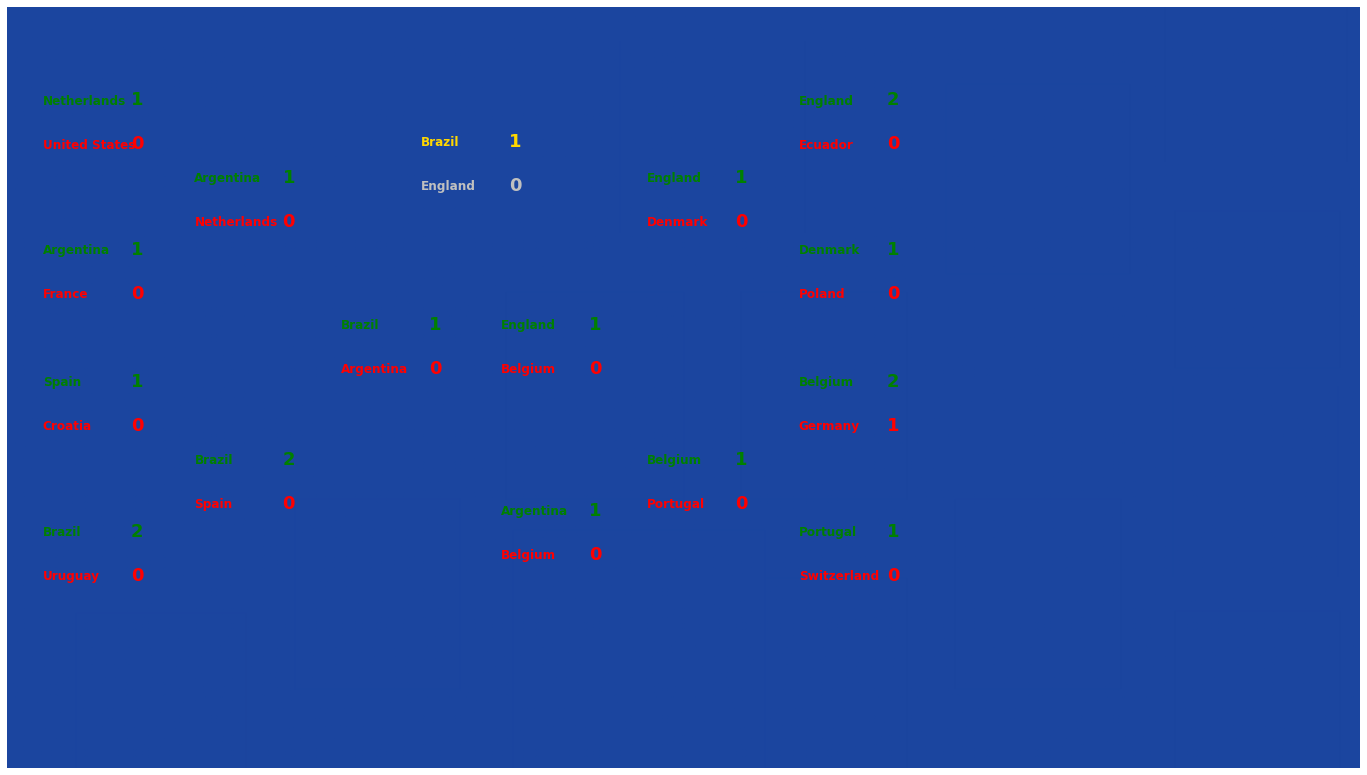

In [26]:
plt.figure(figsize = (25,14))
img = mpimg.imread('tabela.png')
plt.imshow(img)
plt.axis('off')

def text_match(x, y, match, final=False):
    col_win, col_loose = ('green', 'red') if (not final) else ('gold', 'silver')
    plt.text(x, y, match[0], fontsize=12, color=col_win, weight='bold')
    plt.text(x+100, y+1, match[2][0], fontsize=18, color=col_win, weight='bold')
    plt.text(x, y+50, match[1], fontsize=12, color=col_loose, weight='bold')
    plt.text(x+100, y+51, match[2][1], fontsize=18, color=col_loose, weight='bold')


round_of_16_xy = [(40,110),(898,110),(40,280),(898,280),(40,430),(898,430),(40,600),(898,600)]
quarter_finals_xy = [(212,198),(726,198),(212,518),(726,518)]
semi_finals_xy = [(378,365),(560,365)]
x_little_final, y_little_final = 560, 576
x_final, y_final = 469, 157

for (x, y), match in zip(round_of_16_xy, round_of_16):
    text_match(x, y, match)
for (x, y), match in zip(quarter_finals_xy, quarter_finals):
    text_match(x, y, match)
for (x, y), match in zip(semi_finals_xy, semi_finals):
    text_match(x, y, match)
text_match(x_little_final, y_little_final, little_final)
text_match(x_final, y_final, final, final=True)
plt.show()

## Salvando modelo

Após o desenvolvimento deste modelo, foi construida uma aplicação com **streamlit** para o modelo e realizado o deploy com o **heroku**. O deploy pode ser entendido como a implantação do ciclo de vida de um software, que corresponde textualmente á passagem do software para a produção

* Repositório da aplicação desenvolvida:
* A aplicação pode ser conferida em https://possiveis-resultados-qatar2022.herokuapp.com/

In [27]:
import pickle

with open('poisson_model.pkl', 'wb') as file:
    pickle.dump(poisson_model, file)

## Conclusão

Foi possível através dos dados de ranking das seleções, dados de partidas internacionais das seleções e dados de copas anteriores que ocorreram até o ano de 2014,além dos dados da copa atual e elo rating, construir um modelo com capacidade de prever as possíveis vitórias na fase de grupo e na fase de mata-mata, até se chegar no grande vencedor.

## **Referência e créditos**

Esse foi um projeto que foi construído por mim, mas também contei com o apoio de muitos projetos que estão na internet, outros projetos que tinham sido construídos com o mesmo tema mas de forma diferente, a principal questão é que não consegui identificar bons materiais em português, os projetos em sua maioria foi realizado em outro países, então também foi importante entender como esses projetos tinham sido feitos e como eu poderia agregar em meu projeto.

* Sobre o modelo linear generalizado por regressão de poisson

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#poisson-models

https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/

https://en.wikipedia.org/wiki/Poisson_regression

- sobre o algoritmo: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

- sobre a regressão de poisson: http://www.john-ros.com/Rcourse/glm.html / https://en.wikipedia.org/wiki/Poisson_regression

https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html

https://www.kaggle.com/code/nathanlauga/which-team-will-win-the-2018-fifa-world-cup

Documentação statsmodels sobre o GLM: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html

* **Projetos para usar como base**: 

-  https://github.com/christianwbsn/world-cup-2018-predictor/blob/master/notebooks/Who%20Will%20Win%20The%20World%20Cup%202018.ipynb

- https://www.kaggle.com/code/taraskovtun12/soccer-world-cup-2018-winner-f5e44e/notebook

- https://www.kaggle.com/code/nathanlauga/which-team-will-win-the-2018-fifa-world-cup

- https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/ (útil para explicação do modelo e publicações do insta)

* Simulação de quem vai vencer / Etapa de machine learning:
https://www.kaggle.com/code/taraskovtun12/soccer-world-cup-2018-winner-f5e44e/notebook